In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from langdetect import detect
import os

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, concat_ws, udf, array, lit, rand
from pyspark.sql.functions import col, size, explode, split
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, Word2Vec, Word2VecModel
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.feature import PCA as PCAml, PCAModel
from pyspark.ml.linalg import Vectors, DenseVector, SparseVector, VectorUDT
from pyspark.sql.types import BooleanType, FloatType

In [2]:
spark = SparkSession.builder.appName('BDClustering') \
    .config("spark.sql.shuffle.partitions", "100") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.executor.cores", "4") \
    .config("spark.task.cpus", "4") \
    .config("spark.driver.maxResultSize", "8g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/08 10:58:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
import logging
spark.sparkContext.setLogLevel("ERROR")
logging.getLogger("py4j").setLevel(logging.ERROR)

In [22]:
# data_path = "../../data/dblp-ref/dblp-ref-3.json"
data_path = "../../data/dblp-ref/*.json"
df = spark.read.json(data_path)

In [23]:
df = df.repartition(64)
df.cache()

DataFrame[abstract: string, authors: array<string>, id: string, n_citation: bigint, references: array<string>, title: string, venue: string, year: bigint]

In [31]:
num_papers = df.count()
year_range = df.selectExpr("min(year)", "max(year)").collect()
citation_stats = df.selectExpr("min(n_citation)", "max(n_citation)", "avg(n_citation)").collect()
num_venues = df.select("venue").distinct().count()

print(f"Number of papers: {num_papers}")
print(f"Year range: {year_range[0]['min(year)']} - {year_range[0]['max(year)']}")
print(f"Citation stats: Min: {citation_stats[0]['min(n_citation)']}, Max: {citation_stats[0]['max(n_citation)']}, Avg: {citation_stats[0]['avg(n_citation)']}")
print(f"Number of unique venues: {num_venues}")

Number of papers: 3079007
Year range: 1936 - 2018
Citation stats: Min: 0, Max: 73362, Avg: 35.220902713114974
Number of unique venues: 5079


In [25]:
df = df.withColumn("num_authors", size(col("authors")))
authors_stats = df.selectExpr("min(num_authors)", "max(num_authors)", "avg(num_authors)").collect()
print(f"Authors stats: Min: {authors_stats[0]['min(num_authors)']}, Max: {authors_stats[0]['max(num_authors)']}, Avg: {authors_stats[0]['avg(num_authors)']}")

Authors stats: Min: -1, Max: 351, Avg: 3.077667897474738


In [26]:
df_pandas = df.select("year", "n_citation", "num_authors", "venue").toPandas()

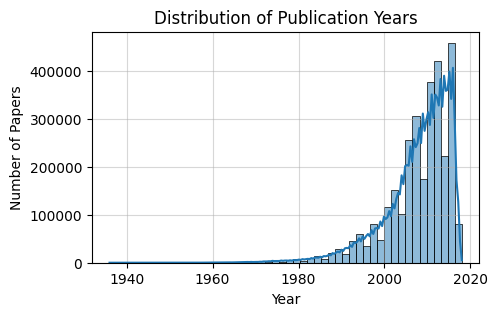

In [27]:
plt.figure(figsize=[5, 3])
sns.histplot(df_pandas['year'], kde=True, bins=50)
plt.title('Distribution of Publication Years')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.grid(True, alpha=0.5)
plt.show()

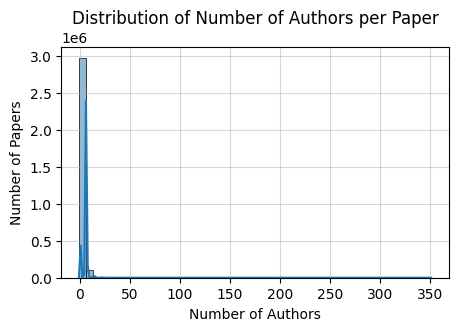

In [29]:
plt.figure(figsize=[5, 3])
sns.histplot(df_pandas['num_authors'], kde=True, bins=50)
plt.title('Distribution of Number of Authors per Paper')
plt.xlabel('Number of Authors')
plt.ylabel('Number of Papers')
plt.grid(True, alpha=0.5)
plt.show()

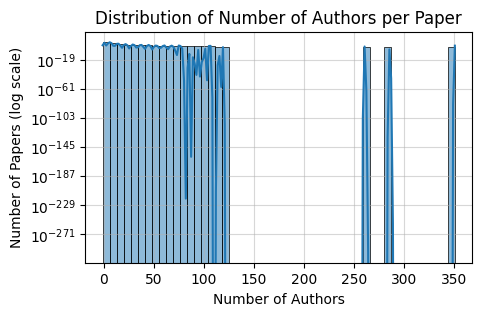

In [28]:
plt.figure(figsize=[5, 3])
sns.histplot(df_pandas['num_authors'], kde=True, bins=50)
plt.title('Distribution of Number of Authors per Paper')
plt.xlabel('Number of Authors')
plt.ylabel('Number of Papers (log scale)')
plt.yscale("log")
plt.grid(True, alpha=0.5)
plt.show()

/tmp/ipykernel_164160/251919318.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_venues.index, x=top_venues.values, palette='magma')


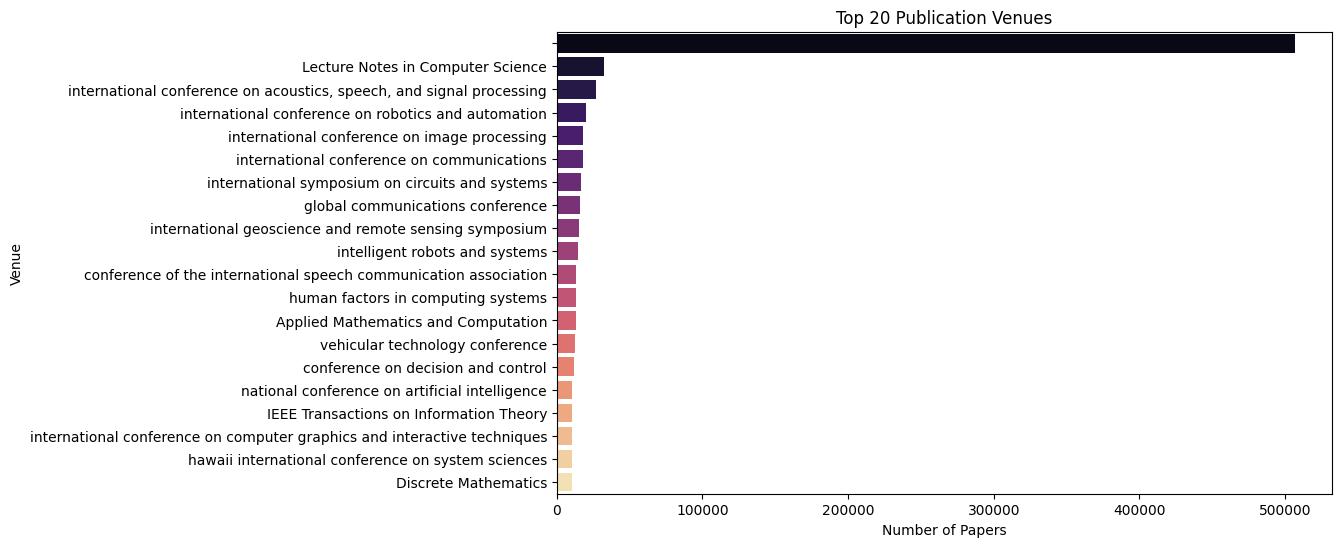

In [9]:
top_venues = df_pandas['venue'].value_counts().head(20)
plt.figure(figsize=[10, 6])
sns.barplot(y=top_venues.index, x=top_venues.values, palette='magma')
plt.title('Top 20 Publication Venues')
plt.xlabel('Number of Papers')
plt.ylabel('Venue')
plt.show()

/tmp/ipykernel_70982/1076992863.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_venues.index, x=top_venues.values, palette='magma')


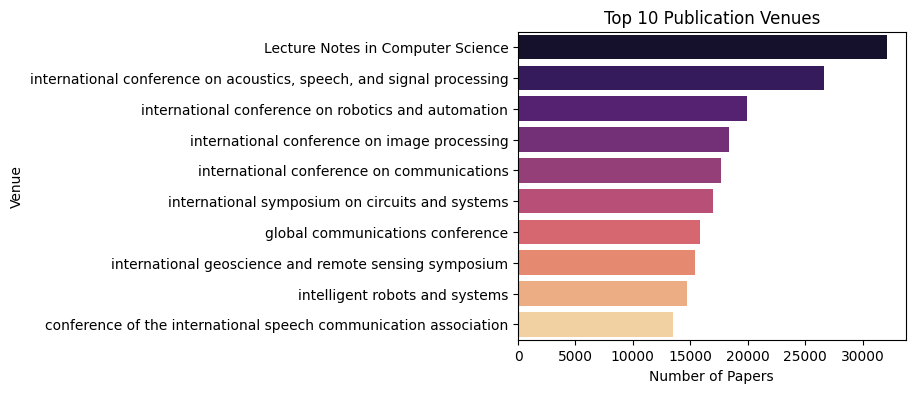

In [34]:
# filter empty vanues.
filtered_df = df_pandas[df_pandas['venue'].notna() & (df_pandas['venue'] != "")]
top_venues = filtered_df['venue'].value_counts().head(10)

plt.figure(figsize=[5, 4])
sns.barplot(y=top_venues.index, x=top_venues.values, palette='magma')
plt.title('Top 10 Publication Venues')
plt.xlabel('Number of Papers')
plt.ylabel('Venue')
plt.show()

/tmp/ipykernel_216179/4247739260.py:4: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=title_word_counts['title_words'], x=title_word_counts['count'], palette='rocket')


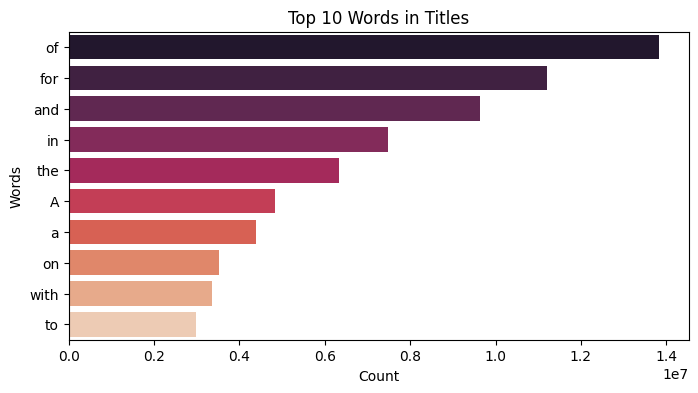

In [10]:
df = df.withColumn("title_words", explode(split(col("title"), " ")))
title_word_counts = df.groupBy("title_words").count().orderBy("count", ascending=False).limit(10).toPandas()
plt.figure(figsize=[8, 4])
sns.barplot(y=title_word_counts['title_words'], x=title_word_counts['count'], palette='rocket')
plt.title('Top 10 Words in Titles')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()

In [35]:
# subsample
df_sample = df_pandas.sample(frac=0.1, random_state=42)

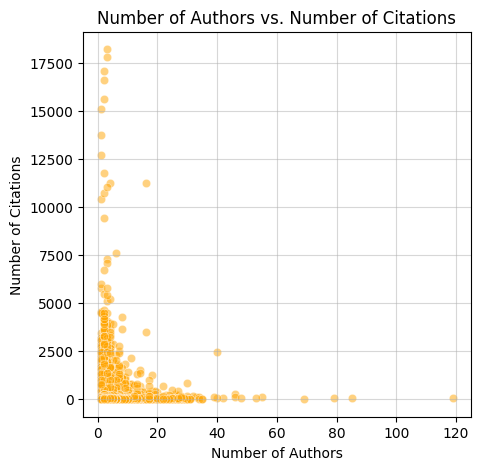

In [41]:
# Scatter plot: Number of Authors vs. Number of Citations
plt.figure(figsize=[5, 5])
sns.scatterplot(data=df_sample, x='num_authors', y='n_citation', color="orange", alpha=0.5)
plt.title('Number of Authors vs. Number of Citations')
plt.xlabel('Number of Authors')
plt.ylabel('Number of Citations')
plt.grid(True, alpha=0.5)
plt.show()

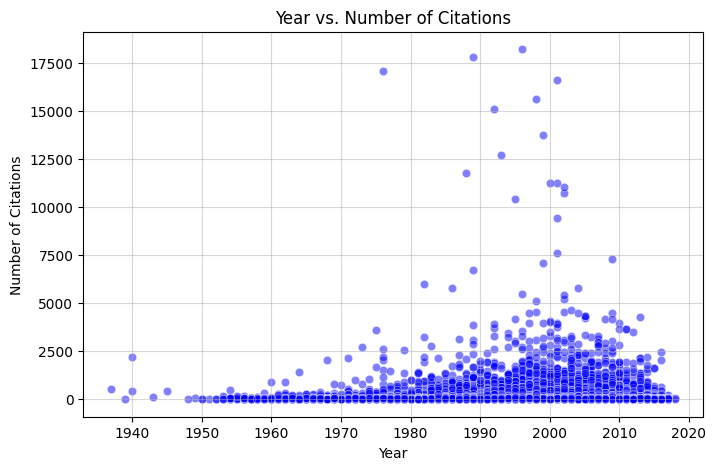

In [40]:
# Scatter plot: Year vs. Number of Citations
plt.figure(figsize=[8, 5])
sns.scatterplot(data=df_sample, x='year', y='n_citation', color="blue", alpha=0.5)
plt.title('Year vs. Number of Citations')
plt.xlabel('Year')
plt.ylabel('Number of Citations')
plt.grid(True, alpha=0.5)
plt.show()

In [13]:
# Define UDF to detect English language
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

is_english_udf = udf(is_english, BooleanType())

# Filter for English documents and combine abstract and title without creating an extra column
df = df.filter(df.abstract.isNotNull() & df.title.isNotNull())
df = df.withColumn("is_english", is_english_udf(col("title")))
df = df.filter(col("is_english") == True).drop("is_english")

In [14]:
df = df.withColumn('title', lower(col('title')))
df = df.withColumn('title', regexp_replace(col('title'), '[^a-zA-Z\s]', ''))

In [15]:
# Tokenize text
tokenizer = Tokenizer(inputCol='title', outputCol='words')
df = tokenizer.transform(df)

In [16]:
# Remove stop words
remover = StopWordsRemover(inputCol='words', outputCol='filtered')
custom_stop_words = ['doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', 'www']
remover.setStopWords(remover.getStopWords() + custom_stop_words)
df = remover.transform(df)

In [18]:
df.show(5)

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+-----------+-----------+--------------------+--------------------+
|            abstract|             authors|                  id|n_citation|          references|               title|               venue|year|num_authors|title_words|               words|            filtered|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+-----------+-----------+--------------------+--------------------+
|The purpose of th...|[Makoto Satoh, Ry...|00127ee2-cb05-48c...|         0|[51c7e02e-f5ed-43...|preliminary desig...|international con...|2013|          8|Preliminary|[preliminary, des...|[preliminary, des...|
|The purpose of th...|[Makoto Satoh, Ry...|00127ee2-cb05-48c...|         0|[51c7e02e-f5ed-43...|preliminary desig...|international con...|2013|          8|     

/tmp/ipykernel_164160/2740412964.py:4: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=title_word_counts['title_words'], x=title_word_counts['count'], palette='magma')


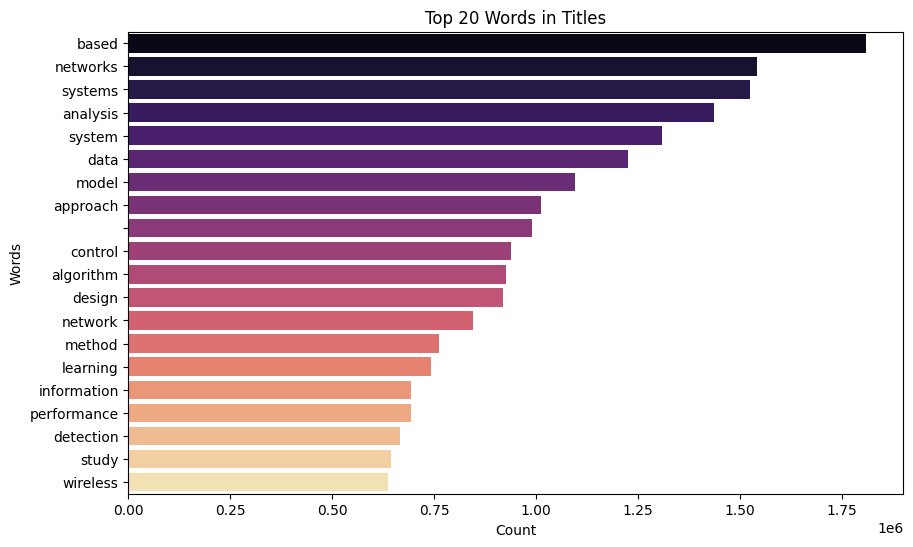

In [21]:
df = df.withColumn("title_words", explode(col("filtered")))
title_word_counts = df.groupBy("title_words").count().orderBy("count", ascending=False).limit(10).toPandas()
plt.figure(figsize=[8, 6])
sns.barplot(y=title_word_counts['title_words'], x=title_word_counts['count'], palette='magma')
plt.title('Top 10 Words in Titles')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()

/tmp/ipykernel_216179/2700605484.py:4: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=title_word_counts['title_words'], x=title_word_counts['count'], palette='rocket')


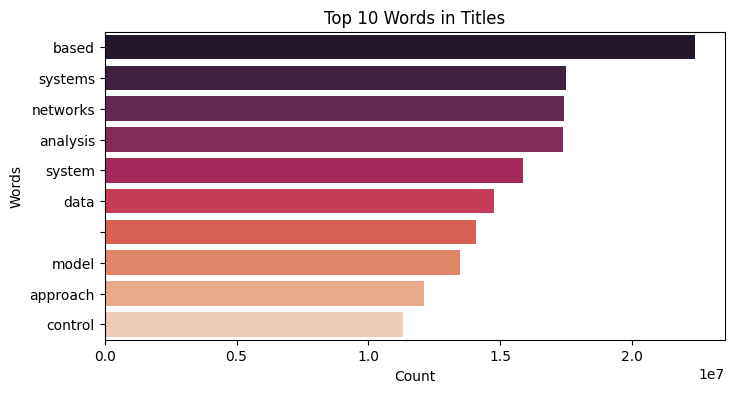

In [15]:
df = df.withColumn("title_words", explode(col("filtered")))
title_word_counts = df.groupBy("title_words").count().orderBy("count", ascending=False).limit(10).toPandas()
plt.figure(figsize=[8, 4])
sns.barplot(y=title_word_counts['title_words'], x=title_word_counts['count'], palette='rocket')
plt.title('Top 10 Words in Titles')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()

/tmp/ipykernel_70982/4107806577.py:5: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=title_word_counts['title_words'], x=title_word_counts['count'], palette='rocket')


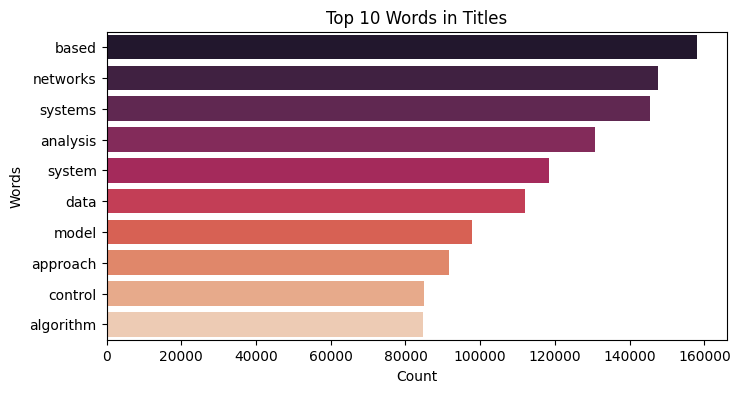

In [17]:
df = df.withColumn("title_words", explode(col("filtered")))
df = df.filter(col("title_words").isNotNull() & (col("title_words") != ""))
title_word_counts = df.groupBy("title_words").count().orderBy("count", ascending=False).limit(10).toPandas()
plt.figure(figsize=[8, 4])
sns.barplot(y=title_word_counts['title_words'], x=title_word_counts['count'], palette='rocket')
plt.title('Top 10 Words in Titles')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()

In [18]:
print("a")

a
